In [1]:
# Cell 1: Import libraries and set random seeds for reproducibility
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pydicom
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ Libraries imported and seeds set!")


✅ Libraries imported and seeds set!


In [2]:
# Cell 2: Load dataset metadata and split data into train and validation sets
# Adjust dataset_path as needed for your Kaggle environment.
dataset_path = "/kaggle/input/rsna-pneumonia-detection-challenge"
train_labels_csv = os.path.join(dataset_path, "stage_2_train_labels.csv")
class_info_csv = os.path.join(dataset_path, "stage_2_detailed_class_info.csv")

# Load CSV files
labels_df = pd.read_csv(train_labels_csv)
class_info_df = pd.read_csv(class_info_csv)

# Merge metadata on 'patientId' and simplify labels
merged_df = pd.merge(labels_df, class_info_df, on="patientId")
labels_simple = merged_df[['patientId', 'Target']].drop_duplicates().reset_index(drop=True)
labels_simple['Target'] = labels_simple['Target'].map({0: 'Normal', 1: 'Pneumonia'})
labels_simple['patientId'] = labels_simple['patientId'].astype(str) + ".dcm"

# Split data: 80% training, 20% validation
train_df, val_df = train_test_split(labels_simple, test_size=0.2, random_state=SEED, stratify=labels_simple['Target'])
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))


Train samples: 21347
Validation samples: 5337


In [3]:
# Cell 3: Define a function to load and preprocess DICOM images
# This function reads a DICOM file, normalizes pixel values, resizes the image to (224,224),
# and converts the image from grayscale to 3-channel RGB (required by ResNet101).
def load_preprocess_dicom(dicom_path, img_size=(224, 224)):
    dicom_data = pydicom.dcmread(dicom_path)
    img_array = dicom_data.pixel_array.astype(np.float32)
    # Normalize pixel values to [0, 1]
    img_norm = (img_array - np.min(img_array)) / (np.max(img_array) - np.min(img_array) + 1e-10)
    # Resize image
    img_resized = cv2.resize(img_norm, img_size)
    # Convert grayscale to RGB by stacking the single channel three times
    img_rgb = np.stack([img_resized] * 3, axis=-1)
    return img_rgb

# Test the function on a sample image
sample_image_path = os.path.join(dataset_path, "stage_2_train_images", train_df.iloc[0]['patientId'])
sample_img = load_preprocess_dicom(sample_image_path)
print("✅ Sample image shape (should be 224x224x3):", sample_img.shape)


✅ Sample image shape (should be 224x224x3): (224, 224, 3)


In [4]:
# Cell 4: Create data generators for training and validation
# This cell creates an infinite data generator for training (loops indefinitely with shuffling)
# and a finite generator for validation.
def data_generator(df, batch_size=64, img_size=(224, 224), infinite=True):
    def gen():
        if infinite:
            while True:
                # Shuffle DataFrame at the start of each epoch
                shuffled_df = df.sample(frac=1).reset_index(drop=True)
                for _, row in shuffled_df.iterrows():
                    patient_id = row['patientId']
                    label = 1 if row['Target'] == 'Pneumonia' else 0
                    dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                    img = load_preprocess_dicom(dicom_path, img_size)
                    yield img, label
        else:
            # Finite generator for validation: one full pass over data
            for _, row in df.iterrows():
                patient_id = row['patientId']
                label = 1 if row['Target'] == 'Pneumonia' else 0
                dicom_path = os.path.join(dataset_path, "stage_2_train_images", patient_id)
                img = load_preprocess_dicom(dicom_path, img_size)
                yield img, label

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((img_size[0], img_size[1], 3), ())
    )
    ds = ds.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 64
train_ds = data_generator(train_df, batch_size=BATCH_SIZE, infinite=True)
val_ds = data_generator(val_df, batch_size=BATCH_SIZE, infinite=False)
print("✅ Data generators created with batch size:", BATCH_SIZE)


✅ Data generators created with batch size: 64


In [5]:
# Cell 5: Build the ResNet101 model with frozen base layers
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# Load the ResNet101 base model with ImageNet weights, excluding the top classifier
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the entire base model
base_model.trainable = False

# Build the full model by adding a global pooling and custom classifier head
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet101 (Functional)               │ (None, 7, 7, 2048)          │      42,658,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,920,577 (163.73 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 42,658,176 (162.73 MB)

In [6]:
# Cell 6: Compute class weights to address class imbalance
y_train = train_df['Target'].apply(lambda x: 1 if x == 'Pneumonia' else 0)
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(weights)}
print("✅ Class weights computed:", class_weights)


✅ Class weights computed: {0: 0.6454314567333858, 1: 2.219022869022869}


In [7]:
# Cell 7: Define callbacks (EarlyStopping and ReduceLROnPlateau)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

print("✅ Callbacks defined.")


✅ Callbacks defined.


In [8]:
# Cell 8: Train the ResNet101 model with the frozen base (initial training of classifier head)
steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
print("Steps per epoch:", steps_per_epoch)

EPOCHS = 10

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,  # One full pass over training data per epoch
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Steps per epoch: 334
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5460 - loss: 0.7069

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


334/334 ━━━━━━━━━━━━━━━━━━━━ 523s 1s/step - accuracy: 0.5460 - loss: 0.7068 - val_accuracy: 0.6895 - val_loss: 0.6352 - learning_rate: 0.0010
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 309s 928ms/step - accuracy: 0.5825 - loss: 0.6695 - val_accuracy: 0.5005 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 311s 934ms/step - accuracy: 0.5958 - loss: 0.6607 - val_accuracy: 0.6189 - val_loss: 0.6427 - learning_rate: 0.0010
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.6255 - loss: 0.6433
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
334/334 ━━━━━━━━━━━━━━━━━━━━ 310s 930ms/step - accuracy: 0.6255 - loss: 0.6433 - val_accuracy: 0.6067 - val_loss: 0.6515 - learning_rate: 0.0010
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 309s 927ms/step - accuracy: 0.6484 - loss: 0.6354 - val_accuracy: 0.7292 - val_loss: 0.5535 - learning_rate: 5.0000e-04
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 287s 860ms/step - accuracy: 0.6449 - 

In [9]:
# Cell 9: Unfreeze the ResNet101 base layers for fine-tuning
# You can choose to unfreeze all layers or only the top layers.
# Here, we unfreeze all layers for fine-tuning.
base_model.trainable = True

# Optionally, to partially unfreeze:
# fine_tune_at = len(base_model.layers) - 50
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False
# for layer in base_model.layers[fine_tune_at:]:
#     layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("✅ Base model layers unfrozen for fine-tuning.")


✅ Base model layers unfrozen for fine-tuning.


In [10]:
# Cell 10: Fine-tune the model with unfrozen base layers
FINE_TUNE_EPOCHS = 10  # Adjust based on performance

fine_tune_history = model.fit(
    train_ds,
    epochs=FINE_TUNE_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights
)


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 442s 980ms/step - accuracy: 0.7110 - loss: 0.6928 - val_accuracy: 0.2252 - val_loss: 10.8338 - learning_rate: 1.0000e-05
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 322s 964ms/step - accuracy: 0.7797 - loss: 0.4302 - val_accuracy: 0.2271 - val_loss: 1.5981 - learning_rate: 1.0000e-05
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 323s 969ms/step - accuracy: 0.8429 - loss: 0.3147 - val_accuracy: 0.3965 - val_loss: 1.9670 - learning_rate: 1.0000e-05
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 319s 958ms/step - accuracy: 0.9231 - loss: 0.1850 - val_accuracy: 0.6266 - val_loss: 1.3485 - learning_rate: 1.0000e-05
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 313s 940ms/step - accuracy: 0.9738 - loss: 0.0845 - val_accuracy: 0.8034 - val_loss: 0.7495 - learning_rate: 1.0000e-05
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 287s 860ms/step - accuracy: 0.9921 - loss: 0.0333 - val_accuracy: 0.7838 - val_loss: 0.8124 - learning_rate: 1.0000e-05
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━

84/84 ━━━━━━━━━━━━━━━━━━━━ 62s 610ms/step - accuracy: 0.2185 - loss: 10.9264
Validation Loss: 10.8338, Validation Accuracy: 0.2252


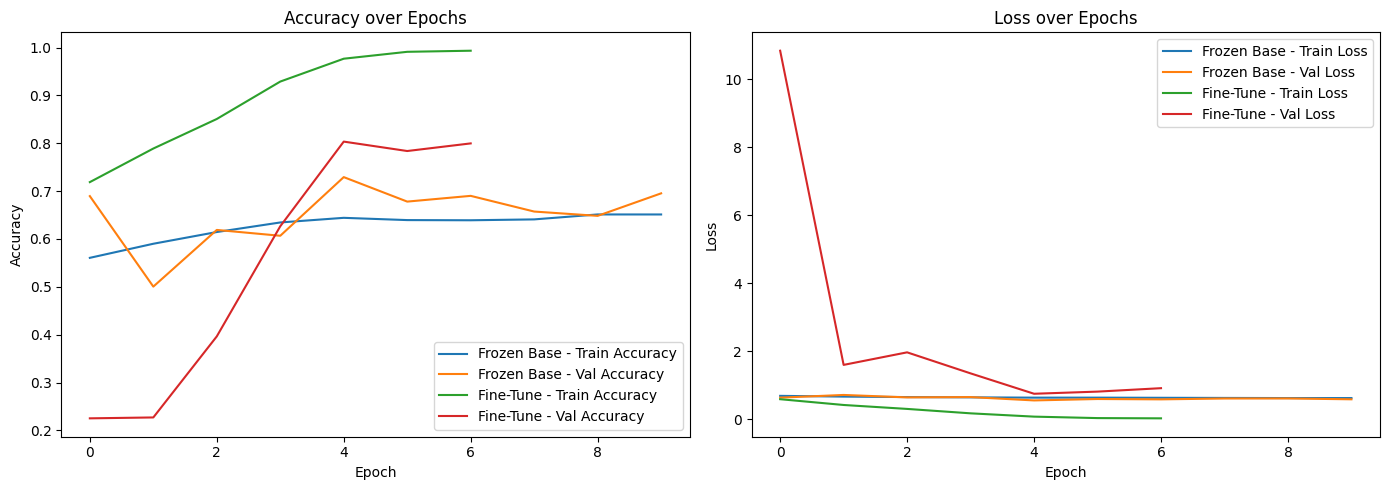

In [11]:
# Cell 11: Evaluate the fine-tuned model on the validation set and plot learning curves
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Frozen Base - Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Frozen Base - Val Accuracy')
plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tune - Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-Tune - Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Frozen Base - Train Loss')
plt.plot(history.history['val_loss'], label='Frozen Base - Val Loss')
plt.plot(fine_tune_history.history['loss'], label='Fine-Tune - Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-Tune - Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━

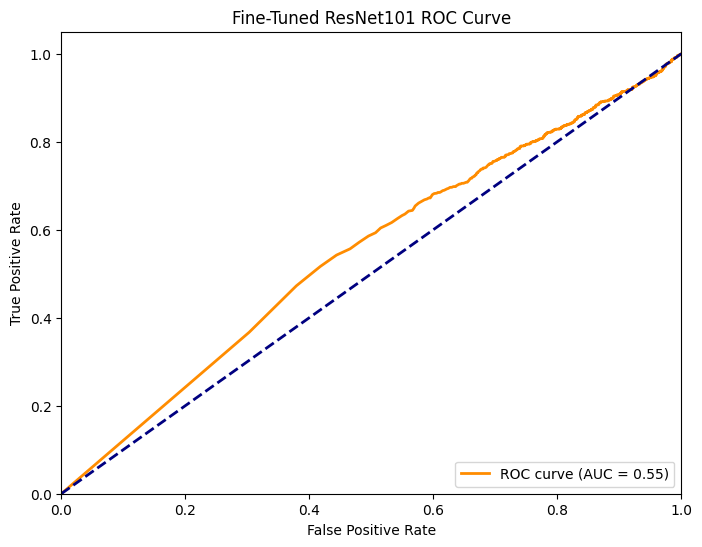

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    confusion_matrix, f1_score, roc_curve, auc
)

def evaluate_model(model, dataset, stage_name=""):
    """
    Evaluates the given Keras model on the specified tf.data.Dataset.
    Prints Accuracy, Precision, Recall, F1-score, Confusion Matrix,
    and plots the ROC curve with AUC.

    Args:
        model: A trained Keras model (fine-tuned).
        dataset: A tf.data.Dataset object (e.g., your val_ds).
        stage_name: A label (string) for printing/plot titles.
    """
    y_true = []
    y_pred = []
    y_scores = []  # Predicted probabilities

    # Gather predictions and true labels
    for images, labels in dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype("int32").flatten())
        y_scores.extend(preds.flatten())

    # Compute evaluation metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Print the evaluation metrics
    print(f"=== {stage_name} Model ===")
    print("Accuracy: {:.2f}%".format(acc * 100))
    print("Precision: {:.2f}".format(prec))
    print("Recall (Sensitivity): {:.2f}".format(rec))
    print("F1-Score: {:.2f}".format(f1))
    print("Confusion Matrix:\n", cm)
    print("AUC: {:.2f}".format(roc_auc))
    print()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{stage_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Example usage for your final fine-tuned model:
evaluate_model(model, val_ds, stage_name="Fine-Tuned ResNet101")
